# Analysis of $Mo_{1-x}Re_xS_2$ images

**Extract statistically significant information about effective interactions between Mo and Re atoms**

## Table of Contents

* [1. Images](#1.-Images)
* [2. Target and random histograms](#2.-Target-and-random-histograms)
* [3. Create and populate lattice](#3.-Create-and-populate-lattice)

**Notebook setup**

In [1]:
%matplotlib inline

import os
import sys
import copy
import pickle
from collections import Counter
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm, chi2
from scipy.optimize import fmin

from subprocess import Popen, PIPE
import multiprocessing as mp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../src/utils')
from utils import *

In [4]:
path_raw = '../data/raw'
path_tmp = "../data/tmp"

## 1. Images

Extract Mo and Re positions for each image

In [6]:
def get_simulation_results(data_dir, names):

    atom_pos = [] 
    atom_ids = []

    for name in names:
        npy_name = os.path.join(data_dir, name +'_sim2.npy')
        mat = np.load(npy_name)
        atom_pos.append(mat[:, 100:])
        atom_ids.append(mat[:, 0:100])

    return atom_pos, atom_ids

In [7]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

In [8]:
atom_pos, atom_ids_sim = get_simulation_results(path_tmp, names)

In [9]:
atom_ids_sim[1].shape

(557, 100)

In [10]:
# Convert atom_ids 2d arrays
#atom_ids = [[aids[:, i] for i in range(aids.shape[1])] for aids in atom_ids_sim]

In [11]:
atom_ids = [[aids[:, i] for aids in atom_ids_sim] for i in range(100)]

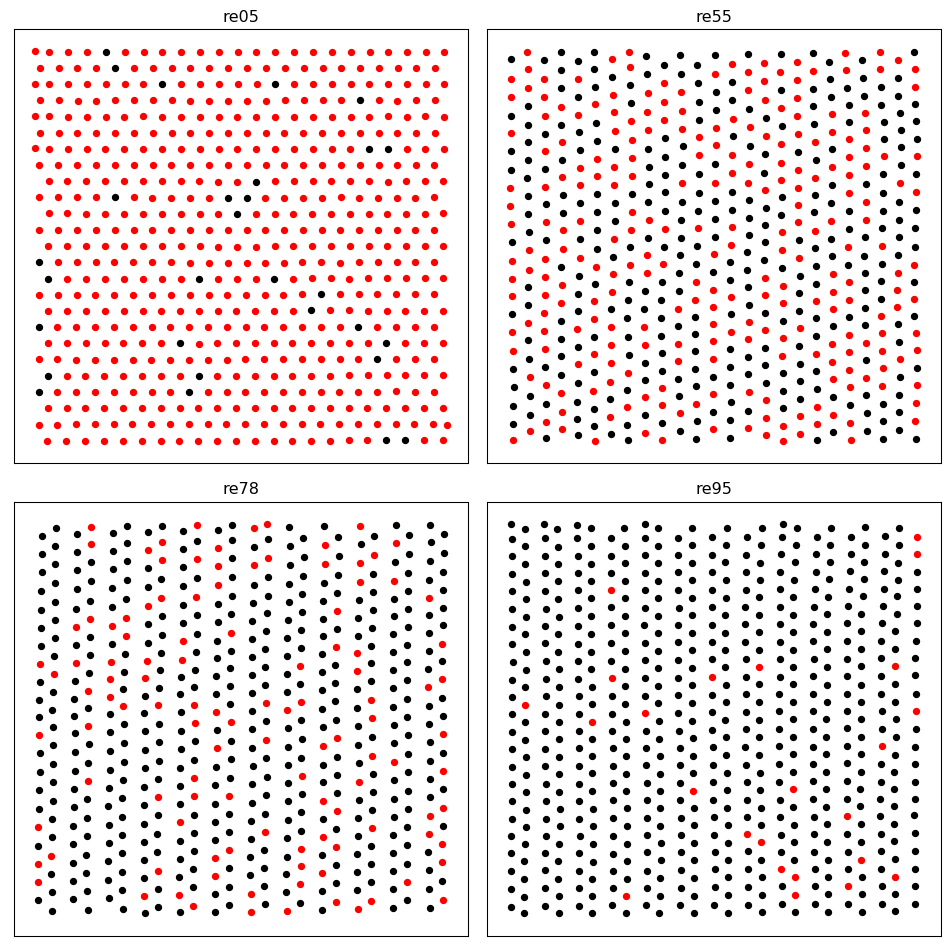

In [14]:
show_positions(names, atom_pos, atom_ids_sim, symbol_size = 20, isim = 59)

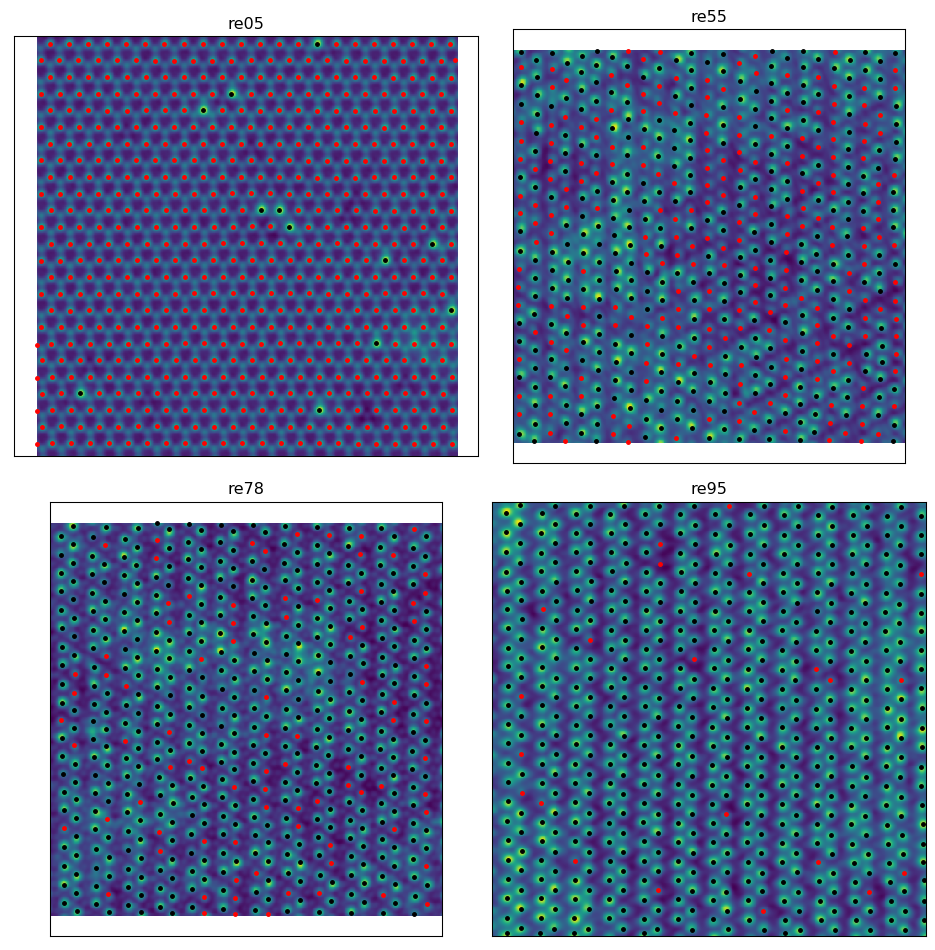

In [15]:
# Separate atoms to Mo and Re based on image-specific intensity threshold
intensity_thresh = [0.80, 0.45, 0.45, 0.45]  # intensity thresholds for each image
atom_pos_orig, atom_ids_orig, intensities = get_atom_positions(path_raw, names, intensity_thresh)

show_images(names, atom_pos_orig, atom_ids_orig, intensities)

### Identify distinct local configurations and collect target histograms

In [16]:
distance_thresh = [45, 32, 30, 26]  # distance thresholds for each image


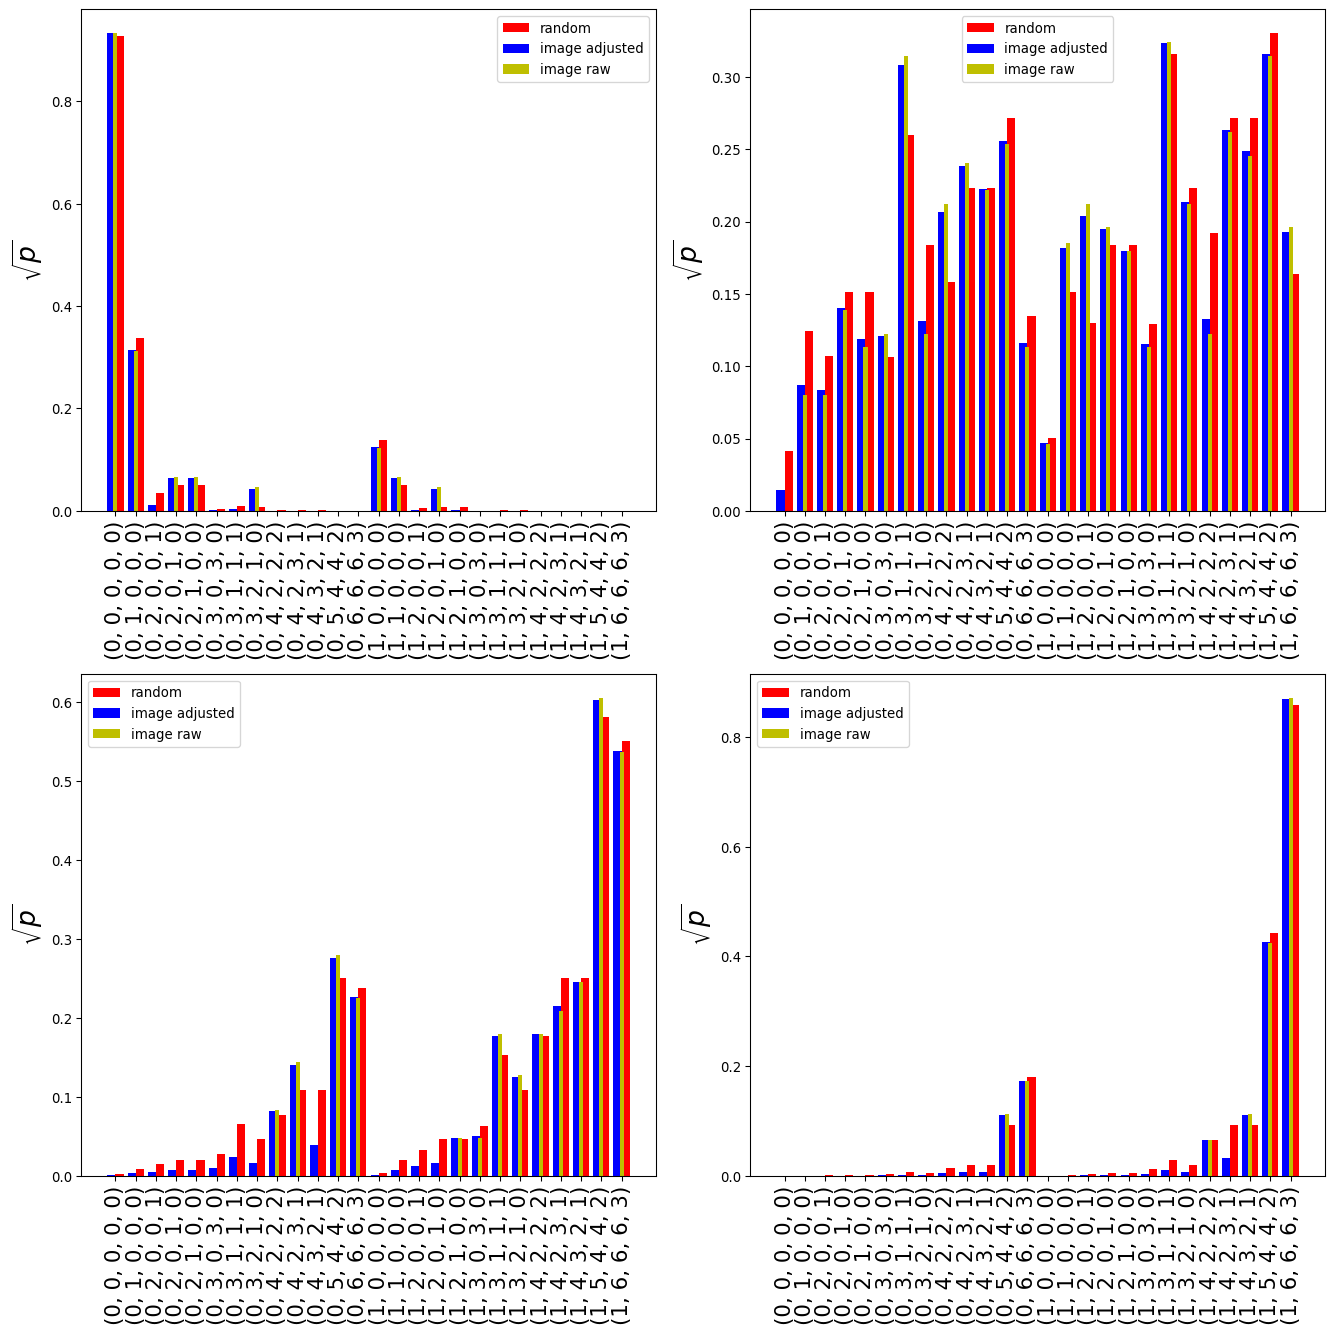

In [17]:
target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids_orig, distance_thresh)

cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

# symmetry number for each configuration
conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

#trans_hist = make_transform_matrix(cfg_types, conf_dict)

# probability of each symmetrized configuration for a given Re concentration
x_re = rhenium_concentration(target_hist)

# random - null hypothesis
prob_conf = random_config_proba(names, conf_counts, x_re)

# applies uninformative multinomial (Jeffrey's) prior to deal with low-sampling-caused zero counts
target_hist_adjusted = apply_prior(names, conf_counts, cfg_types, target_hist, prob_conf)

# get estimated probability distribution of the target for model optimization
gsv = get_probability_histogram(names, cfg_types, target_hist_adjusted)
#gsv = get_probability_histogram(names, cfg_types, target_hist)

plot_histograms(names, num_samples, target_hist, target_hist_adjusted, prob_conf, cfg_types, x_re)

## 2. Target and random histograms

**Comparison of target (adjusted) and random (null) histograms of local configurations**

In [23]:
probs = {'re05': [], 're55': [], 're78': [], 're95': []}
for i in range(100):
    print("iter:", i)
    target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids[i], distance_thresh)
    cfg_types = sorted(set([c for h in target_hist.values() for c in h]))
    cfg_labels = [str(c) for c in cfg_types]
    for name in names:
        all_counts = np.array([target_hist[name].get(cfg, 0) for cfg in cfg_types])
        all_counts = all_counts/float(num_samples[name])
        probs[name].append(all_counts)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
iter: 18
iter: 19
iter: 20
iter: 21
iter: 22
iter: 23
iter: 24
iter: 25
iter: 26
iter: 27
iter: 28
iter: 29
iter: 30
iter: 31
iter: 32
iter: 33
iter: 34
iter: 35
iter: 36
iter: 37
iter: 38
iter: 39
iter: 40
iter: 41
iter: 42
iter: 43
iter: 44
iter: 45
iter: 46
iter: 47
iter: 48
iter: 49
iter: 50
iter: 51
iter: 52
iter: 53
iter: 54
iter: 55
iter: 56
iter: 57
iter: 58
iter: 59
iter: 60
iter: 61
iter: 62
iter: 63
iter: 64
iter: 65
iter: 66
iter: 67
iter: 68
iter: 69
iter: 70
iter: 71
iter: 72
iter: 73
iter: 74
iter: 75
iter: 76
iter: 77
iter: 78
iter: 79
iter: 80
iter: 81
iter: 82
iter: 83
iter: 84
iter: 85
iter: 86
iter: 87
iter: 88
iter: 89
iter: 90
iter: 91
iter: 92
iter: 93
iter: 94
iter: 95
iter: 96
iter: 97
iter: 98
iter: 99


In [35]:
fp = open(os.path.join(path_tmp, "probs.pickle"), mode = "wb")
pickle.dump(probs, fp)
fp.close()

In [37]:
fn = open(os.path.join(path_tmp, "probs.pickle"), mode = "rb")
xx = pickle.load(fn)
fn.close()

In [54]:
proba = { k:np.stack(probs[k]) for k in probs }

In [60]:
p_mean = { k:np.mean(proba[k], axis = 0) for k in proba}
p_std = { k:np.std(proba[k], axis = 0) for k in proba}

In [81]:
def plot_bar_stats(names, p_mean, p_std, prob_conf, cfg_types):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), dpi = 96)

    cfg_labels = [str(c) for c in cfg_types]
    for i, name in enumerate(names):
        p_array = [(k, v) for k, v in prob_conf[name].items()]
        all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

        nconf = len(cfg_labels)
        width = 0.4

        ir, ic = divmod(i, 2)
        axs[ir, ic].bar(np.arange(nconf)+0.2, all_counts_p, width, color='r', label='random', yerr = all_counts_p/nconf)
        axs[ir, ic].bar(np.arange(nconf)-0.2, p_mean[name], width, color='b', label='sim', yerr = p_std[name])

        axs[ir, ic].legend()
        axs[ir, ic].set_xticks(range(nconf))
        axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0, fontsize=16)
        #axs[ir, ic].set_title('Image: ' + name + '\nActual Re concentration: ' + str(x_re[name]))#', Total number of samples: n = ' + str(n_sample))
        axs[ir, ic].set_ylabel(r'$\sqrt{p}$', fontsize=20)

        plt.tight_layout()

    plt.show()

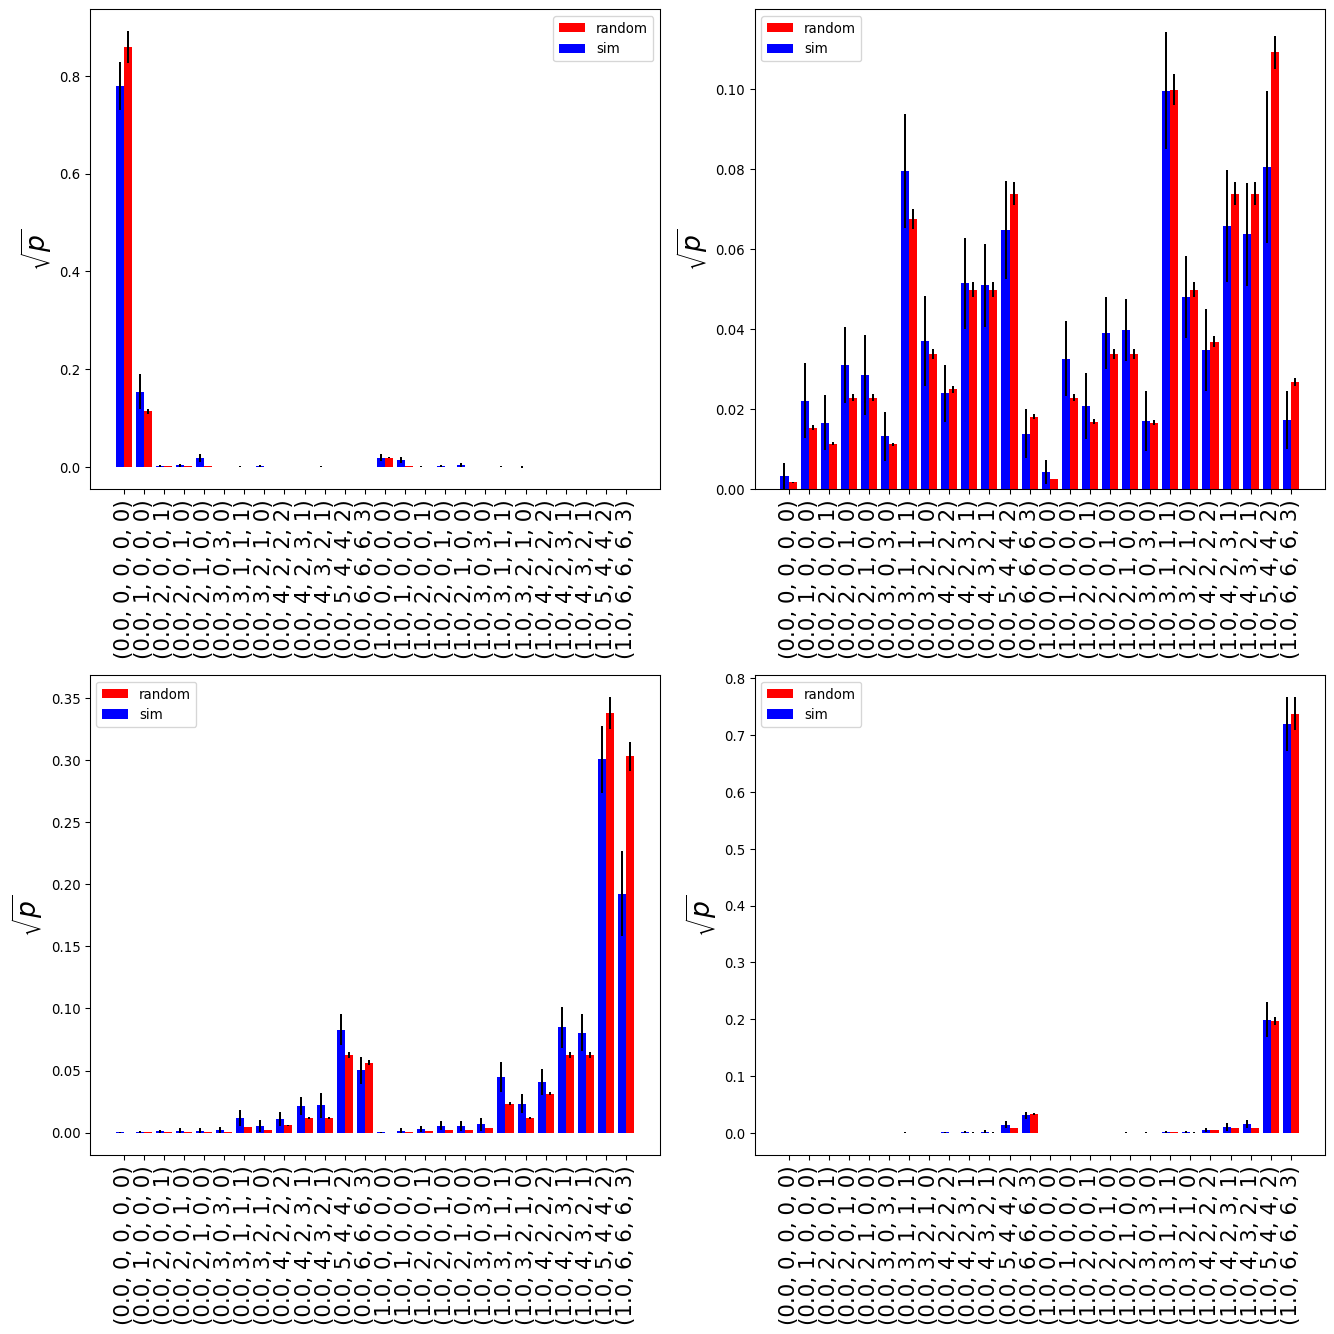

In [82]:
plot_bar_stats(names, p_mean, p_std, prob_conf, cfg_types)

In [173]:
p_std

{'re05': array([0.0490841 , 0.03520021, 0.00222672, 0.00357161, 0.00772129,
        0.        , 0.00116539, 0.00223307, 0.        , 0.00021444,
        0.00074001, 0.00021444, 0.        , 0.00679953, 0.00599785,
        0.00121457, 0.00179424, 0.00427159, 0.00042233, 0.00148238,
        0.00192897, 0.        , 0.00030172, 0.00047755, 0.        ,
        0.        ]),
 're55': array([0.00327111, 0.00939424, 0.00685769, 0.00958464, 0.00993736,
        0.00608243, 0.01428263, 0.01118798, 0.00717342, 0.01130824,
        0.01035774, 0.01221699, 0.00611102, 0.00298113, 0.00933908,
        0.008183  , 0.00899085, 0.00773378, 0.00745646, 0.01466085,
        0.01022496, 0.01022547, 0.01394241, 0.012865  , 0.01899949,
        0.0072841 ]),
 're78': array([0.00022926, 0.00104959, 0.00147609, 0.00214608, 0.00216148,
        0.00215459, 0.00655978, 0.00473579, 0.00561569, 0.0071916 ,
        0.01013563, 0.01269575, 0.01095309, 0.00032258, 0.00192448,
        0.00261447, 0.00375795, 0.00365888, 0.00

In [174]:
p_mean

{'re05': array([7.79568966e-01, 1.53922414e-01, 1.83189655e-03, 3.36206897e-03,
        1.85775862e-02, 0.00000000e+00, 5.60344828e-04, 1.98275862e-03,
        0.00000000e+00, 2.15517241e-05, 2.37068966e-04, 2.15517241e-05,
        0.00000000e+00, 1.89870690e-02, 1.38577586e-02, 6.89655172e-04,
        1.35775862e-03, 3.31896552e-03, 8.62068966e-05, 7.97413793e-04,
        7.11206897e-04, 0.00000000e+00, 4.31034483e-05, 6.46551724e-05,
        0.00000000e+00, 0.00000000e+00]),
 're55': array([0.00339056, 0.02218884, 0.01660944, 0.0310515 , 0.02862661,
        0.01328326, 0.07948498, 0.03708155, 0.0239485 , 0.05143777,
        0.05092275, 0.06484979, 0.01390558, 0.0043133 , 0.03261803,
        0.02075107, 0.03903433, 0.03978541, 0.01699571, 0.0995279 ,
        0.04811159, 0.03478541, 0.06572961, 0.06366953, 0.08053648,
        0.01736052]),
 're78': array([2.30414747e-05, 3.45622120e-04, 8.29493088e-04, 1.49769585e-03,
        1.38248848e-03, 1.93548387e-03, 1.16820276e-02, 5.39170507e-

In [157]:
s2dist = { nam:np.mean(np.sum((proba[nam]**0.5 - p_mean[nam]**0.5)**2, axis = 1)**0.5) for nam in names}
s2dist

{'re05': 0.12343955323858889,
 're55': 0.1382080314863903,
 're78': 0.14801830097858748,
 're95': 0.10985277623334078}

In [158]:
sdist = { nam:np.mean(np.arccos(np.sum((proba[nam]*p_mean[nam])**0.5, axis = 1))) for nam in names}
sdist

{'re05': 0.12352664088161608,
 're55': 0.13833213440898454,
 're78': 0.14816904786166818,
 're95': 0.1099174393190345}

In [169]:
prand = {}
mrand = {}
for nam in names:
    p_array = [(k, v) for k, v in prob_conf[nam].items()]
    prand[nam] = np.array([prob_conf[nam].get(cfg, 0) for cfg in cfg_types])
    mrand[nam] = np.random.multinomial(num_samples[nam], prand[nam], 100)/num_samples[nam]

In [176]:
rdist = { nam:np.mean(np.arccos(np.sum((prand[nam]*mrand[nam])**0.5, axis = 1))) for nam in names}
rdist

{'re05': 0.07319658713305949,
 're55': 0.12079182604952476,
 're78': 0.12429676259190706,
 're95': 0.07811626462204048}

In [179]:
{ nam: rdist[nam]/sdist[nam] for nam in names }

{'re05': 0.5925570922244111,
 're55': 0.8732014912196674,
 're78': 0.8388848034439117,
 're95': 0.7106812631916273}

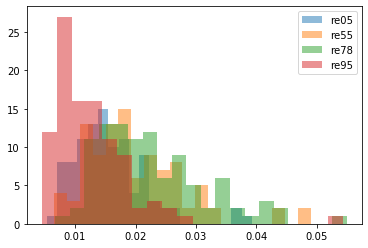

In [151]:
for nam in names:
    plt.hist(sqdist[nam], bins = 20, alpha = 0.5, label = nam)
plt.legend()

<BarContainer object of 26 artists>

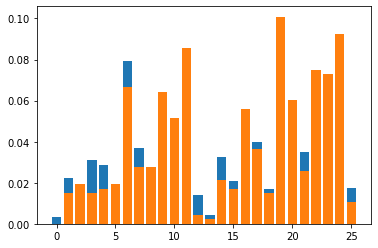

In [120]:
plt.bar(range(26), p_mean[nam])
plt.bar(range(26), proba[nam][0])

In [117]:
p_mean[name]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.24628450e-05, 2.76008493e-04, 0.00000000e+00,
       4.67091295e-04, 1.08280255e-03, 1.44373673e-03, 1.44161359e-02,
       3.07855626e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.24628450e-05, 1.06157113e-04, 1.69851380e-04, 1.25265393e-03,
       1.23142251e-03, 4.73460722e-03, 9.61783439e-03, 1.55414013e-02,
       1.98917197e-01, 7.19872611e-01])

In [ ]:
for i in range(100):
    target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids[i], distance_thresh)
    cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

    # symmetry number for each configuration
    conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

    # probability of each symmetrized configuration for a given Re concentration
    x_re = rhenium_concentration(target_hist)

    # random - null hypothesis
    prob_conf = random_config_proba(names, conf_counts, x_re)

    # applies uninformative multinomial (Jeffrey's) prior to deal with low-sampling-caused zero counts
    target_hist_adjusted = apply_prior(names, conf_counts, cfg_types, target_hist, prob_conf)

    # get estimated probability distribution of the target for model optimization
    gsv = get_probability_histogram(names, cfg_types, target_hist_adjusted)
    #gsv = get_probability_histogram(names, cfg_types, target_hist)

    plot_histograms(names, num_samples, target_hist, target_hist_adjusted, prob_conf, cfg_types, x_re)

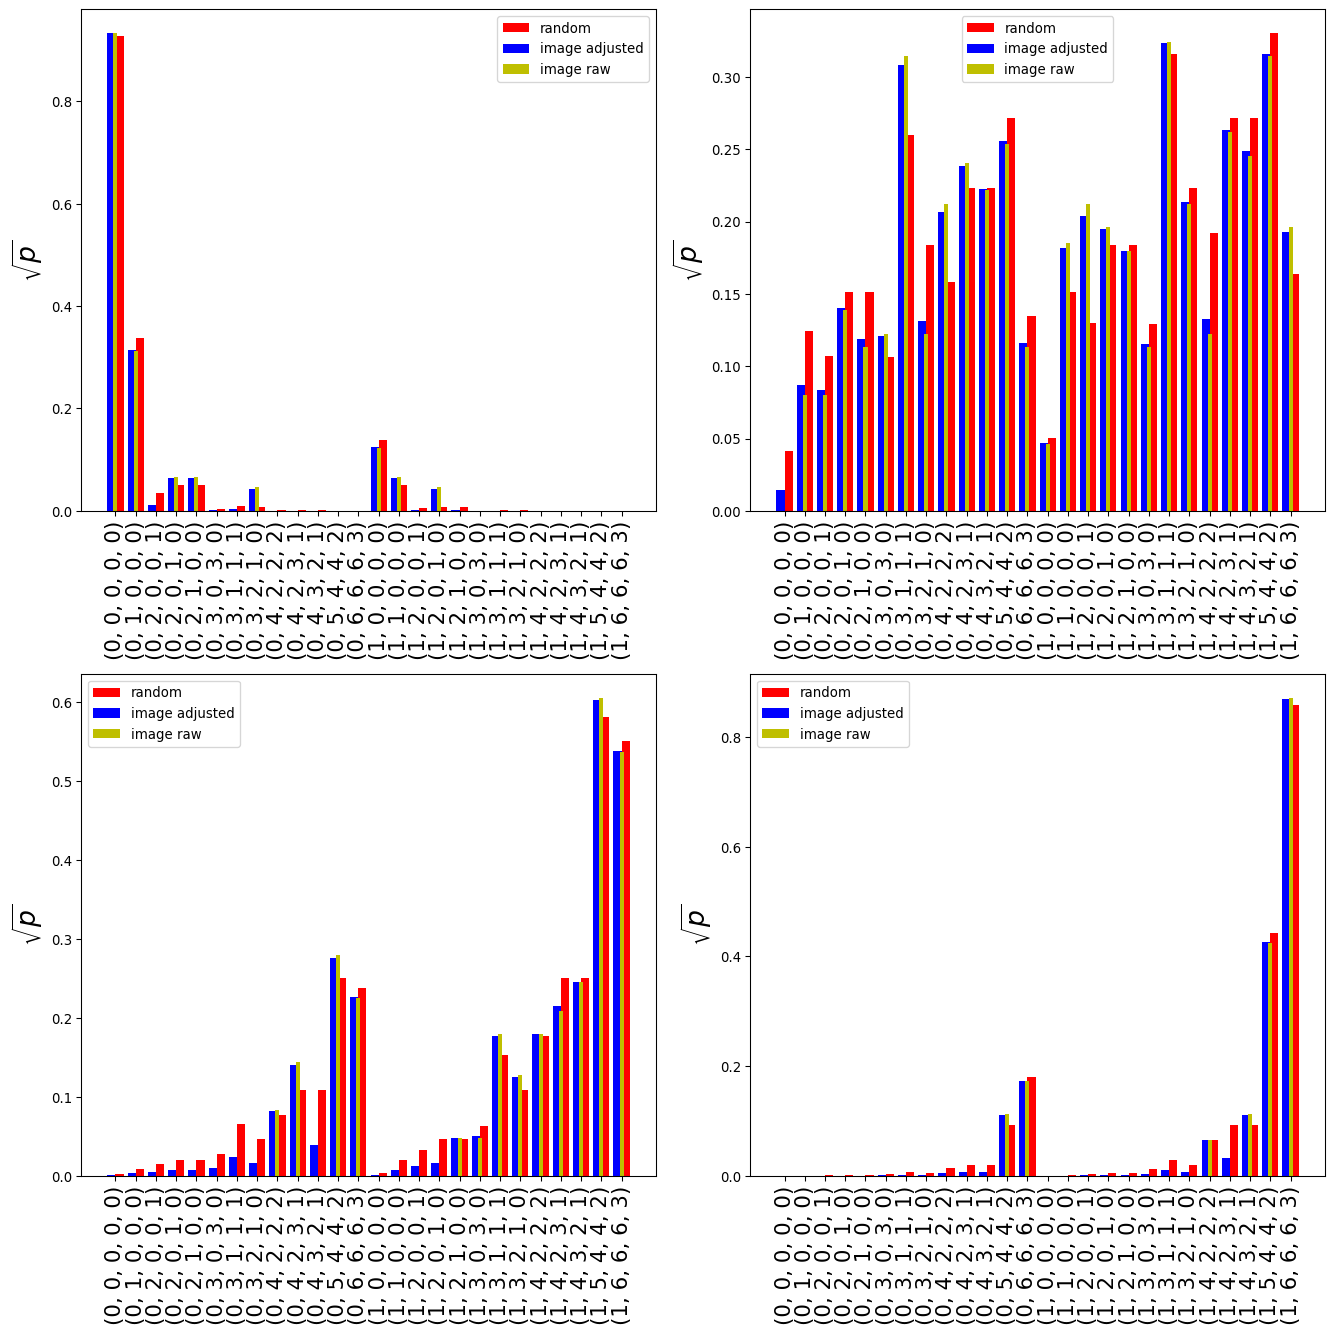

In [63]:
target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids_orig, distance_thresh)

cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

# symmetry number for each configuration
conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

#trans_hist = make_transform_matrix(cfg_types, conf_dict)

# probability of each symmetrized configuration for a given Re concentration
x_re = rhenium_concentration(target_hist)

# random - null hypothesis
prob_conf = random_config_proba(names, conf_counts, x_re)

# applies uninformative multinomial (Jeffrey's) prior to deal with low-sampling-caused zero counts
target_hist_adjusted = apply_prior(names, conf_counts, cfg_types, target_hist, prob_conf)

# get estimated probability distribution of the target for model optimization
gsv = get_probability_histogram(names, cfg_types, target_hist_adjusted)
#gsv = get_probability_histogram(names, cfg_types, target_hist)

plot_histograms(names, num_samples, target_hist, target_hist_adjusted, prob_conf, cfg_types, x_re)

## 3. Create and populate lattice

* Define a hexagonal lattice by mapping from square lattice